In [29]:
import os
import yaml
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [44]:

def extract_scalar_from_event_file(event_path, tag):
    try:
        ea = EventAccumulator(event_path)
        ea.Reload()
        available_tags = ea.Tags().get("scalars", [])
        print(f"Tags in {event_path}: {available_tags}")
        if tag not in available_tags:
            print(f"Tag {tag} not found in {event_path}")
            return None
        events = ea.Scalars(tag)
        return events[-1].value if events else None
    except Exception as e:
        print(f"Error reading {event_path}: {e}")
        return None

def parse_experiment(logs_dir):
    results = []
    print(f"Checking logs directory: {logs_dir}")
    if not os.path.exists(logs_dir):
        print(f"Logs directory {logs_dir} does not exist")
        return results

    for run_dir in sorted(os.listdir(logs_dir)):
        run_path = os.path.join(logs_dir, run_dir, "version_0")
        hparam_path = os.path.join(run_path, "hparams.yaml")
        print(f"\nProcessing run: {run_dir}")
        print(f"Run path: {run_path}")
        print(f"Hparams path exists: {os.path.exists(hparam_path)}")
        if not os.path.exists(hparam_path):
            print(f"Skipping {run_dir}: No hparams.yaml")
            continue

        try:
            with open(hparam_path, "r") as f:
                hparams = yaml.load(f, Loader=yaml.UnsafeLoader)
        except Exception as e:
            print(f"Error reading hparams.yaml in {run_dir}: {e}")
            continue

        event_files = [f for f in os.listdir(run_path) if f.startswith("events.out.tfevents")]
        print(f"Event files: {event_files}")
        if not event_files:
            print(f"Skipping {run_dir}: No event files")
            continue

        event_path = os.path.join(run_path, event_files[0])
        metrics = {
            "roi_loss": extract_scalar_from_event_file(event_path, "roi_loss_epoch"),
            "base_loss": extract_scalar_from_event_file(event_path, "base_loss_epoch"),
            "ssim": extract_scalar_from_event_file(event_path, "val_metrics/ssim"),
            "nmse": extract_scalar_from_event_file(event_path, "val_metrics/nmse"),
            "psnr": extract_scalar_from_event_file(event_path, "val_metrics/psnr"),
        }
        print(f"Metrics for {run_dir}: {metrics}")

        results.append({
            "run": run_dir,
            "alpha": hparams.get("alpha"),
            "sobel_threshold": hparams.get("sobel_threshold"),
            "dilation_size": hparams.get("dilation_size"),
            **metrics,
        })

    print(f"Total runs processed: {len(results)}")
    return results

def print_results_table(results):
    print(f"{'Run':<20} {'Alpha':<8} {'Sobel Thr':<12} {'Dil Size':<10} {'ROI Loss':<10} {'Base Loss':<10} {'SSIM':<8} {'NMSE':<8} {'PSNR':<8}")
    print("-" * 110)
    for r in results:
        alpha = r['alpha'] if r['alpha'] is not None else 'N/A'
        sobel_threshold = r['sobel_threshold'] if r['sobel_threshold'] is not None else 'N/A'
        dilation_size = r['dilation_size'] if r['dilation_size'] is not None else 'N/A'
        roi_loss = r['roi_loss'] if r['roi_loss'] is not None else 'N/A'
        base_loss = r['base_loss'] if r['base_loss'] is not None else 'N/A'
        ssim = r['ssim'] if r['ssim'] is not None else 'N/A'
        nmse = r['nmse'] if r['nmse'] is not None else 'N/A'
        psnr = r['psnr'] if r['psnr'] is not None else 'N/A'
        print(f"{r['run']:<20} {alpha:<8} {sobel_threshold:<12} {dilation_size:<10} {roi_loss:<10} {base_loss:<10} {ssim:<8} {nmse:<8} {psnr:<8}")


In [51]:
results = parse_experiment("sobel_roi_unet_checkpoints\logs")

Checking logs directory: sobel_roi_unet_checkpoints\logs

Processing run: alpha1.0_sobel0.3_dil9
Run path: sobel_roi_unet_checkpoints\logs\alpha1.0_sobel0.3_dil9\version_0
Hparams path exists: True
Event files: ['events.out.tfevents.1745707401.BeetRoot.62560.0']
Tags in sobel_roi_unet_checkpoints\logs\alpha1.0_sobel0.3_dil9\version_0\events.out.tfevents.1745707401.BeetRoot.62560.0: ['hp_metric', 'loss', 'epoch', 'validation_loss', 'val_metrics/nmse', 'val_metrics/ssim', 'val_metrics/psnr']
Tag roi_loss_epoch not found in sobel_roi_unet_checkpoints\logs\alpha1.0_sobel0.3_dil9\version_0\events.out.tfevents.1745707401.BeetRoot.62560.0
Tags in sobel_roi_unet_checkpoints\logs\alpha1.0_sobel0.3_dil9\version_0\events.out.tfevents.1745707401.BeetRoot.62560.0: ['hp_metric', 'loss', 'epoch', 'validation_loss', 'val_metrics/nmse', 'val_metrics/ssim', 'val_metrics/psnr']
Tag base_loss_epoch not found in sobel_roi_unet_checkpoints\logs\alpha1.0_sobel0.3_dil9\version_0\events.out.tfevents.1745707401

In [12]:
# results

In [56]:
print_results_table(results)

Run                  Alpha    Sobel Thr    Dil Size   ROI Loss   Base Loss  SSIM     NMSE     PSNR    
--------------------------------------------------------------------------------------------------------------
alpha1.0_sobel0.3_dil9 1.0      0.3          9          N/A        N/A        0.7148239612579346 0.03617335483431816 31.50077247619629
alpha1.0_sobel0.4_dil9 1.0      0.4          9          N/A        N/A        0.6997614502906799 0.03988802433013916 30.903738021850586


In [ ]:
import pandas as pd 

df = pd.DataFrame(results)
df = df.sort_values(by=["ssim", "nmse"], ascending=[False, True])
# df = df.sort_values(by=["alpha", "ssim", "nmse"], ascending=[False, False, True])
# df = df.sort_values(by=["nmse", "ssim"], ascending=[True, False])

df

,run,alpha,sobel_threshold,dilation_size,roi_loss,base_loss,ssim,nmse,psnr
12,alpha1.5_sobel0.3_dil9,1.50,0.3,9,None,None,0.716448,0.035734,31.579283
5,alpha0.75_sobel0.5_dil9,0.75,0.5,9,None,None,0.714971,0.036159,31.505190
6,alpha1.0_sobel0.3_dil9,1.00,0.3,9,None,None,0.711877,0.036247,31.498001
2,alpha0.25_sobel0.5_dil9,0.25,0.5,9,None,None,0.713653,0.036381,31.481590
14,alpha1.5_sobel0.5_dil9,1.50,0.5,9,None,None,0.712494,0.036438,31.455379
3,alpha0.75_sobel0.3_dil9,0.75,0.3,9,None,None,0.714326,0.036458,31.460970
11,alpha1.25_sobel0.5_dil9,1.25,0.5,9,None,None,0.710041,0.036596,31.403618
0,alpha0.25_sobel0.3_dil9,0.25,0.3,9,None,None,0.714074,0.036655,31.437897
10,alpha1.25_sobel0.4_dil9,1.25,0.4,9,None,None,0.711106,0.036808,31.380854
1,alpha0.25_sobel0.4_dil9,0.25,0.4,9,None,None,0.711188,0.036867,31.391088


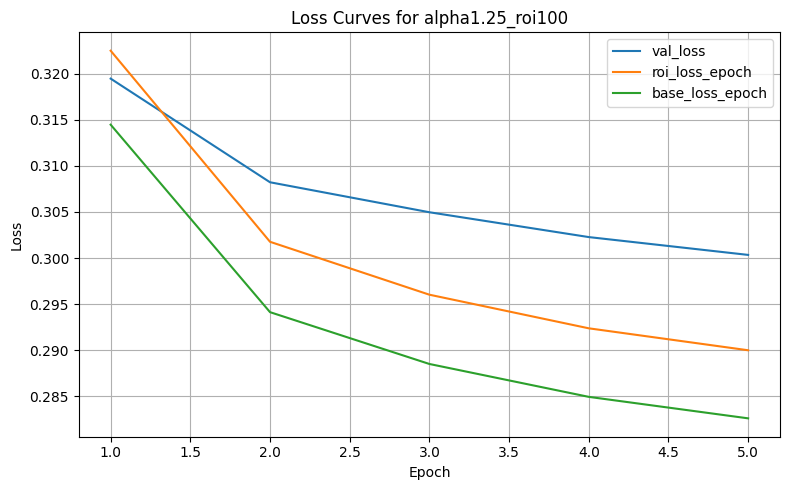

In [ ]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# The specific runs you want to visualize
target_runs = {
    "alpha1.25_roi100",
    "alpha1.0_roi100",
    "alpha0.75_roi100"
}

# Tags to plot
tags_to_plot = ["val_loss", "roi_loss_epoch", "base_loss_epoch"]

# Base log dir
logs_dir = "roi_unet_checkpoints/logs"

# Loop over each desired run
for run_dir in sorted(target_runs):
    run_path = os.path.join(logs_dir, run_dir, "version_0")
    event_files = [f for f in os.listdir(run_path) if f.startswith("events.out.tfevents")]

    if not event_files:
        print(f"No event file found for {run_dir}")
        continue

    event_path = os.path.join(run_path, event_files[0])
    ea = EventAccumulator(event_path)
    ea.Reload()

    # Start a new figure for this run
    plt.figure(figsize=(8, 5))

    for tag in tags_to_plot:
        if tag not in ea.Tags().get("scalars", []):
            print(f"Tag {tag} not found in {run_dir}")
            continue

        events = ea.Scalars(tag)
        epochs = list(range(1, len(events) + 1))
        values = [e.value for e in events]

        plt.plot(epochs, values, label=tag)

    plt.title(f"Loss Curves for {run_dir}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
